In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install darts "darts[torch]" prophet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.3 MB/s eta 0:00:00


# 1.Load dataset

In [ ]:
# install or import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import lightgbm as lgb
import darts as dt
from sklearn.metrics import mean_absolute_percentage_error, r2_score,root_mean_squared_error,root_mean_squared_log_error
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [ ]:
# read the dataset
# Upload the dataset and change the path to your own one.
data_path = "/content/drive/My Drive/Appled-Data-Science/Data/SeoulBikeData.csv"
try:
    df = pd.read_csv(data_path, encoding='cp949')
    display(df.head())
except FileNotFoundError:
    print("File not found. Please check the file path.")
except UnicodeDecodeError:
    print("Could not decode the file using cp949. Please try a different encoding.")

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# 2.Data Prepossessing and EDA

In [ ]:
# Rename the columns
new_columns = ["date","hourly_count","hour","temperature","humidity","wind_speed","visibility","dew_point_temperature","solar_radiation","rainfall","sonwfall","seasons","holiday","functioning_day"]
df.columns = new_columns
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df.replace({"No Holiday": "non_holiday", "Holiday": "holiday"})
df.head()


,date,hourly_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,sonwfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,non_holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,non_holiday,Yes


In [ ]:
# Change the type of hour to object
# It can be converted into dummy variables in the next steps.
df['hour'] = df['hour'].astype(str)

In [ ]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00')
df.set_index('datetime', inplace=True)
df.head()

,date,hourly_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,sonwfall,seasons,holiday,functioning_day
datetime,,,,,,,,,,,,,,
2017-12-01 00:00:00,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
2017-12-01 01:00:00,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
2017-12-01 02:00:00,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,non_holiday,Yes
2017-12-01 03:00:00,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,non_holiday,Yes
2017-12-01 04:00:00,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,non_holiday,Yes


# 3.Feature Engineering


## Hourly Features

In [ ]:
# Change the type of hour to object
# It can be converted into dummy variables in the next steps.

# Separate numerical and categorical columns.
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['hourly_count', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation', 'rainfall', 'sonwfall']
Categorical Features: ['hour', 'seasons', 'holiday', 'functioning_day']


In [ ]:
categorical_features.remove('hour')

In [ ]:
# Convert categorical columns into dummy variables using one-hot encoding.
df_categorical = df[categorical_features]
df_dummies = pd.get_dummies(df_categorical)

df_dummies = df_dummies.replace({False: 0, True: 1})
df_dummies['date'] = df['date']
df_dummies['hour'] = df['hour']
display(df_dummies.head())

/tmp/ipython-input-1988603043.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies = df_dummies.replace({False: 0, True: 1})


,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_holiday,holiday_non_holiday,functioning_day_No,functioning_day_Yes,date,hour
datetime,,,,,,,,,,
2017-12-01 00:00:00,0,0,0,1,0,1,0,1,2017-12-01,0
2017-12-01 01:00:00,0,0,0,1,0,1,0,1,2017-12-01,1
2017-12-01 02:00:00,0,0,0,1,0,1,0,1,2017-12-01,2
2017-12-01 03:00:00,0,0,0,1,0,1,0,1,2017-12-01,3
2017-12-01 04:00:00,0,0,0,1,0,1,0,1,2017-12-01,4


## Split the data into training and test data

In [ ]:
df_hour_merged = pd.merge(df[numerical_features], df_dummies, left_index=True, right_index=True)
df_hour_merged.head()

,hourly_count,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,sonwfall,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_holiday,holiday_non_holiday,functioning_day_No,functioning_day_Yes,date,hour
datetime,,,,,,,,,,,,,,,,,,,
2017-12-01 00:00:00,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1,2017-12-01,0
2017-12-01 01:00:00,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1,2017-12-01,1
2017-12-01 02:00:00,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,1,0,1,0,1,2017-12-01,2
2017-12-01 03:00:00,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1,2017-12-01,3
2017-12-01 04:00:00,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1,2017-12-01,4


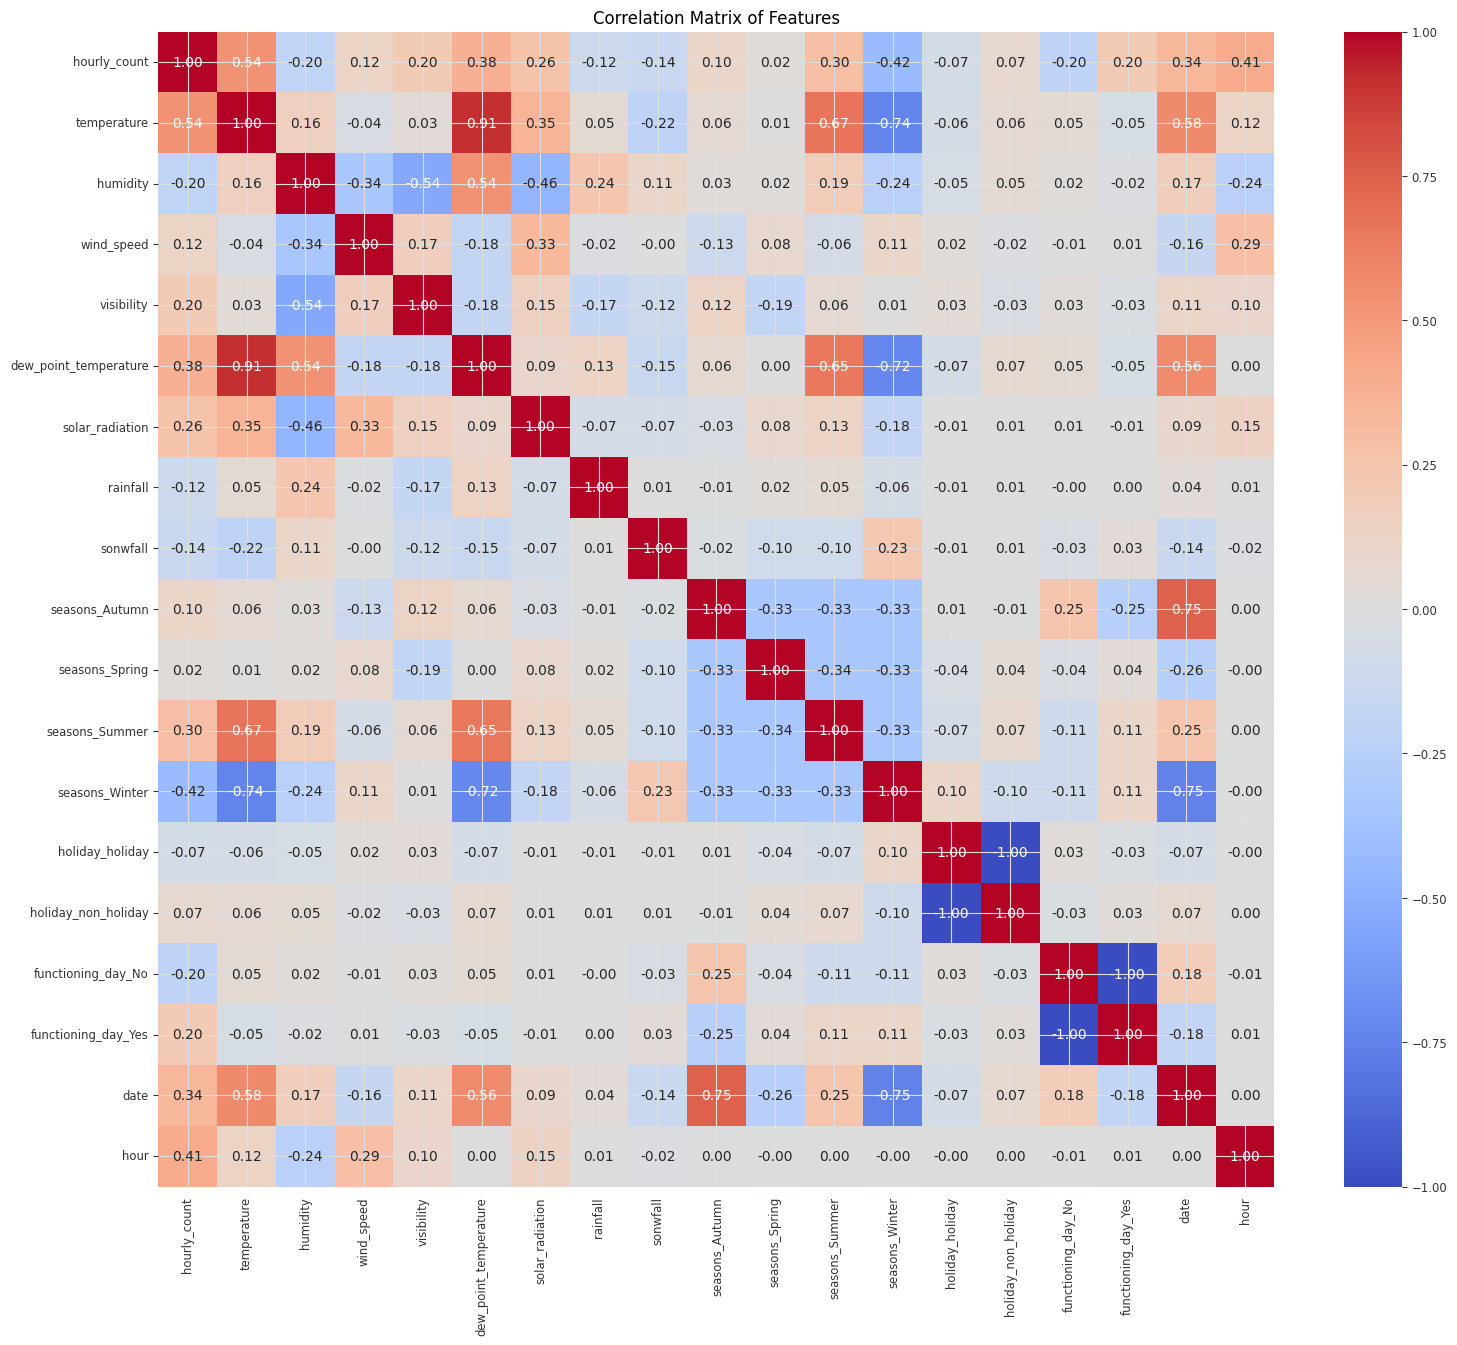

In [ ]:
correlation_matrix = df_hour_merged.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Transform the dataframe into time series
from darts import TimeSeries

ts_series = TimeSeries.from_dataframe(df_hour_merged[['hourly_count']])
features_series = TimeSeries.from_dataframe(df_hour_merged.drop(['hourly_count','date','hour'], axis=1))
ts_series = ts_series.resample(freq="h")
features_series = features_series.resample(freq="h")

# 4.Modeling and Evaluation
Develope baseline model and lightgbm model. Predict one-days rented bike count in advance for evaluation.

## Prophet Model

###hourly prediction

In [ ]:
!pip uninstall prophet
!pip install prophet

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/prophet-1.1.7.dist-info/*
    /usr/local/lib/python3.12/dist-packages/prophet.libs/libtbb-ff323302.so.2
    /usr/local/lib/python3.12/dist-packages/prophet.libs/libtbbmalloc-4dcb68e3.so.2
    /usr/local/lib/python3.12/dist-packages/prophet/*
Proceed (Y/n)? y
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 121.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from darts.models import Prophet
from darts.metrics import mae, rmse, mape
import matplotlib.pyplot as plt


In [ ]:
# Darts Prophet model can directly use TimeSeries objects!
# Pass Prophet parameters through kwargs dictionary, build the predict model
prophet_model_h = Prophet(
    suppress_stdout_stderror=True,  # Suppress prophet warnings

    add_seasonalities={
        'name':"hourly_seasonality",
        'seasonal_periods':24,
        'fourier_order':7
        },
    # Pass Prophet-specific parameters as kwargs
    **{
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'seasonality_mode': 'multiplicative',
        # Other optional parameters:
        # 'changepoint_prior_scale': 0.05,  # Trend flexibility
        # 'seasonality_prior_scale': 10.0,  # Seasonality strength
        # 'holidays_prior_scale': 10.0,     # Holiday effect
        # 'n_changepoints': 25,             # Number of changepoints
    }
)

print("Prophet model created!")

Prophet model created!


In [ ]:
from os import truncate
# Generate monthly covariates for the entire time series
monthly_cov = datetime_attribute_timeseries(ts_series, "month", cyclic=True)


# Stack the monthly covariate onto the existing features_series
features_series = features_series.stack(monthly_cov)

print("monthly_cov added to features_series.")

monthly_cov added to features_series.


In [ ]:
# create train and validation splits
validation_cutoff = pd.Timestamp("2018-11-28")
ts_train, ts_val = ts_series.split_before(validation_cutoff)
features_train, features_val = features_series.split_before(validation_cutoff)

In [ ]:
# train mode with expanding window mode
preds_prophet_hourly=prophet_model_h.historical_forecasts(series=ts_series, past_covariates=None,
                         future_covariates=features_series, forecast_horizon=1,
                         num_samples=1, train_length=None, val_length=0,
                         start=len(ts_train),start_format='value', stride=1,
                         retrain=True, apply_globally=True, overlap_end=False,
                         last_points_only=True, verbose=False, show_warnings=True,
                         predict_likelihood_parameters=False, enable_optimization=True,
                         data_transformers=None, fit_kwargs=None, predict_kwargs=None,
                         sample_weight=None, random_state=None)

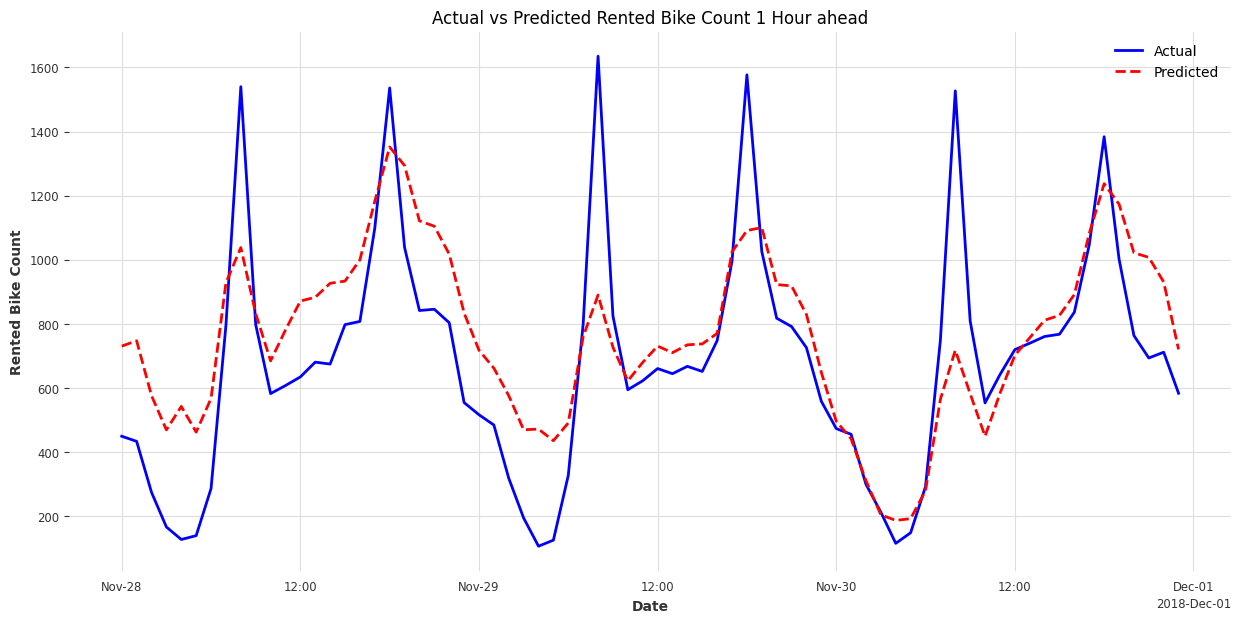

In [ ]:
#crrate plot to compare the prediction with the actual
plt.figure(figsize=(15, 7))
ts_val.plot(label='Actual', color='blue')
preds_prophet_hourly.plot(label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Rented Bike Count 1 Hour ahead')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

In [ ]:
from darts.metrics import mae, rmse, smape

# Extract values from TimeSeries objects
y_true = ts_val.values().flatten()
y_pred = preds_prophet_hourly.values().flatten()

# evaluation
mae_val = mae(ts_val, preds_prophet_hourly)
rmse_val = rmse(ts_val, preds_prophet_hourly)
mape_val = mape(ts_val, preds_prophet_hourly)
smape_val = smape(ts_val, preds_prophet_hourly)
r2_val =  r2_score(y_true, y_pred)

print("Validation set performance evaluation (iterative 1-hour ahead):")
print(f"MAE:   {mae_val:.2f}")
print(f"RMSE:  {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"sMAPE: {smape_val:.2f}%")
print(f"R2: {r2_val:.2f}")

Validation set performance evaluation (iterative 1-hour ahead):
MAE:   178.12
RMSE:  236.36
MAPE: 43.06%
sMAPE: 29.02%
R2: 0.56


###daily prediction

In [ ]:
#change the dataset into daily-based
df_daily = df_hour_merged.resample("D").agg({
    "hourly_count": "sum",       # 每日总量，可改为 mean
    "temperature": "mean",
    "humidity": "mean",
    "wind_speed": "mean",
    "visibility": "mean",
    "dew_point_temperature": "mean",
    "solar_radiation": "sum",
    "rainfall": "sum",
    "sonwfall": "sum",


    # One-hot：取一天中出现最多的情况（max）
    "seasons_Autumn": "max",
    "seasons_Spring": "max",
    "seasons_Summer": "max",
    "seasons_Winter": "max",

    "holiday_holiday": "max",
    "holiday_non_holiday": "max",

    "functioning_day_No": "max",
    "functioning_day_Yes": "max",
})


In [ ]:
from darts import TimeSeries

ts_daily = TimeSeries.from_dataframe(df_daily, value_cols="hourly_count")
features_daily = TimeSeries.from_dataframe(df_daily.drop(columns=["hourly_count"]))


In [ ]:
# create train and validation splits
validation_cutoff = pd.Timestamp("2018-11-01")
daily_ts_train, daily_ts_val = ts_daily.split_before(validation_cutoff)
daily_features_train, daily_features_val = features_daily.split_before(validation_cutoff)

In [ ]:
#create the model
daily_prophet = Prophet(
    suppress_stdout_stderror=True,  # Suppress prophet warnings
    country_holidays='KR',
    add_seasonalities={
        'name':"quarterly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },
    # Pass Prophet-specific parameters as kwargs
    **{
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'seasonality_mode': 'multiplicative',
        # Other optional parameters:
        # 'changepoint_prior_scale': 0.05,  # Trend flexibility
        # 'seasonality_prior_scale': 10.0,  # Seasonality strength
        # 'holidays_prior_scale': 10.0,     # Holiday effect
        #'n_changepoints': 25,             # Number of changepoints
    }
)

In [ ]:
#prediction in expanding window mode
preds_prophet_daily=daily_prophet.historical_forecasts(series=ts_daily, past_covariates=None,
                         future_covariates=features_daily, forecast_horizon=1,
                         num_samples=1, train_length=None, val_length=0,
                         start=len(daily_ts_train),start_format='value', stride=1,
                         retrain=True, apply_globally=True, overlap_end=False,
                         last_points_only=True, verbose=False, show_warnings=True,
                         predict_likelihood_parameters=False, enable_optimization=True,
                         data_transformers=None, fit_kwargs=None, predict_kwargs=None,
                         sample_weight=None, random_state=None)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#remove the predicted values less than 0
preds_prophet_daily = TimeSeries.from_times_and_values(
    preds_prophet_daily.time_index,
    np.maximum(preds_prophet_daily.values(), 0),
    columns=preds_prophet_daily.columns
)

In [ ]:
from darts.metrics import mae, rmse, smape
from sklearn.metrics import r2_score

# evaluation
mae_val = mae(daily_ts_val, preds_prophet_daily)
rmse_val = rmse(daily_ts_val, preds_prophet_daily)

r2_score = r2_score(daily_ts_val.values(), preds_prophet_daily.values())

#mape_val = mape(daily_ts_val, preds_prophet_daily)
#smape_val = smape(daily_ts_val, preds_prophet_daily)

print("Validation set performance evaluation")
print(f"MAE:   {mae_val:.2f}")
print(f"RMSE:  {rmse_val:.2f}")
#print(f"MAPE: {mape_val:.2f}%")
#print(f"sMAPE: {smape_val:.2f}%")
print(f"R2: {r2_score:.2f}")

Validation set performance evaluation
MAE:   1217.60
RMSE:  1787.58
R2: 0.93


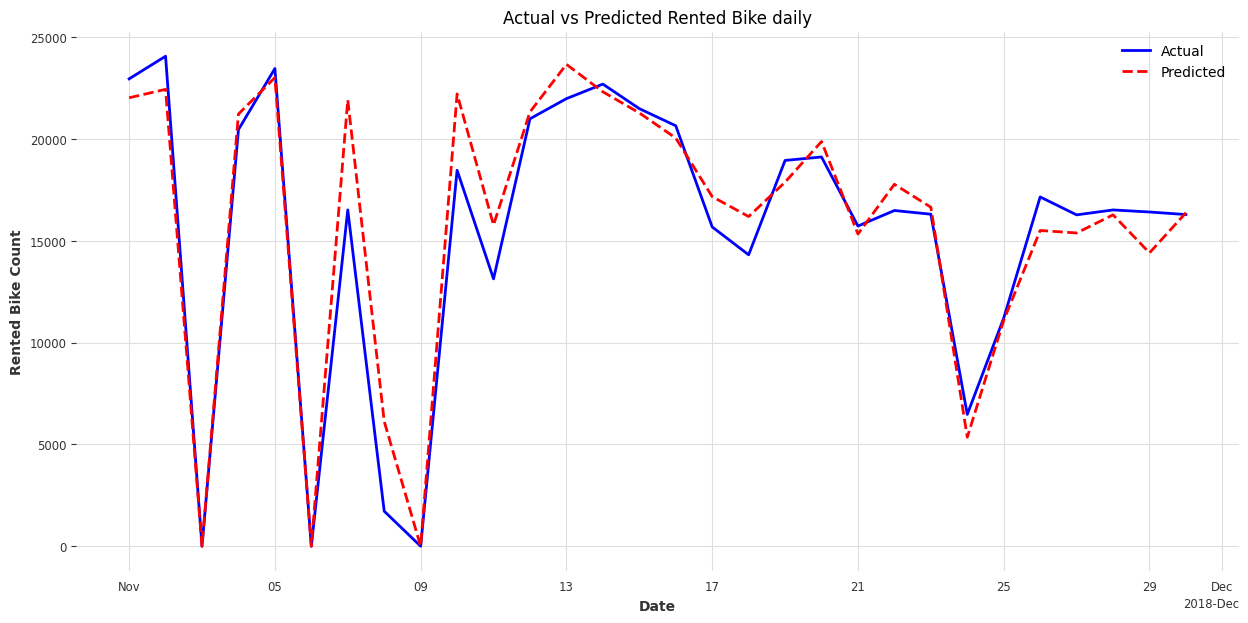

In [ ]:
plt.figure(figsize=(15, 7))
daily_ts_val.plot(label='Actual', color='blue')
preds_prophet_daily.plot(label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Rented Bike daily')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

###weekly prediction

In [ ]:
#change the dataset into 3-days
df_weekly = df_hour_merged.resample("3D").agg({
    "hourly_count": "sum",
    "temperature": "mean",
    "humidity": "mean",
    "wind_speed": "mean",
    "visibility": "mean",
    "dew_point_temperature": "mean",
    "solar_radiation": "sum",
    "rainfall": "sum",
    "sonwfall": "sum",

    # One-hot：每周最常出现的情况
    "seasons_Autumn": "max",
    "seasons_Spring": "max",
    "seasons_Summer": "max",
    "seasons_Winter": "max",

    "holiday_holiday": "max",
    "holiday_non_holiday": "max",

    "functioning_day_No": "max",
    "functioning_day_Yes": "max",
})

In [ ]:
ts_weekly = TimeSeries.from_dataframe(df_weekly, value_cols="hourly_count")
features_weekly = TimeSeries.from_dataframe(df_weekly.drop(columns=["hourly_count"]))


In [ ]:
#split the dataset into training and validation set
validation_cutoff = pd.Timestamp("2018-11-01")
weekly_ts_train, weekly_ts_val = ts_weekly.split_before(validation_cutoff)
weekly_features_train, weekly_features_val = features_weekly.split_before(validation_cutoff)


In [ ]:
#bulid the prediction model
weekly_prophet = Prophet(
    suppress_stdout_stderror=True,  # Suppress prophet warnings
    country_holidays='KR',
    daily_seasonality=False,
    add_seasonalities={
        'name':"quarterly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },
    # Pass Prophet-specific parameters as kwargs
    **{
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        #'seasonality_mode': 'multiplicative',
        # Other optional parameters:
        # 'changepoint_prior_scale': 0.05,  # Trend flexibility
        # 'seasonality_prior_scale': 10.0,  # Seasonality strength
        # 'holidays_prior_scale': 10.0,     # Holiday effect
        # 'n_changepoints': 25,             # Number of changepoints
    }
)


In [ ]:
#make predictions
preds_prophet_3D=weekly_prophet.historical_forecasts(series=ts_weekly, past_covariates=None,
                         future_covariates=features_weekly, forecast_horizon=1,
                         num_samples=1, train_length=None, val_length=0,
                         start=len(weekly_ts_train),start_format='value', stride=1,
                         retrain=True, apply_globally=True, overlap_end=False,
                         last_points_only=True, verbose=False, show_warnings=True,
                         predict_likelihood_parameters=False, enable_optimization=True,
                         data_transformers=None, fit_kwargs=None, predict_kwargs=None,
                         sample_weight=None, random_state=None)

In [ ]:
from darts.metrics import mae, rmse, smape
from sklearn.metrics import r2_score

# evaluation
mae_val = mae(weekly_ts_val, preds_prophet_3D)
rmse_val = rmse(weekly_ts_val, preds_prophet_3D)
mape_val = mape(weekly_ts_val, preds_prophet_3D)
smape_val = smape(weekly_ts_val, preds_prophet_3D)
r2_score = r2_score(weekly_ts_val.values(), preds_prophet_3D.values())

print("Validation set performance evaluation")
print(f"MAE:   {mae_val:.2f}")
print(f"RMSE:  {rmse_val:.2f}")
print(f"RMSE:  {rmse_val:.2f}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"R2: {r2_score:.2f}")

Validation set performance evaluation
MAE:   7758.35
RMSE:  8616.02
RMSE:  8616.02
sMAPE: 19.47%
R2: 0.51


<Figure size 1500x700 with 0 Axes>

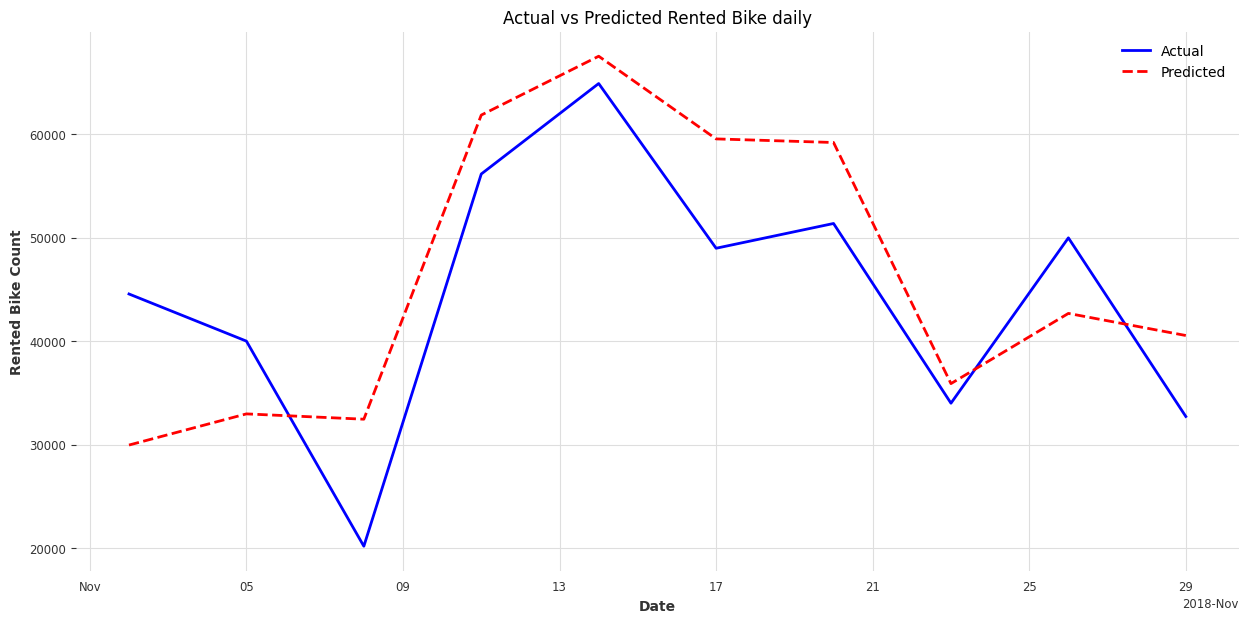

In [ ]:
plt.figure(figsize=(15, 7))
plt.figure(figsize=(15, 7))
weekly_ts_val.plot(label='Actual', color='blue')
preds_prophet_3D.plot(label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Rented Bike daily')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()